![](grid.png)

# ELC-144x142x79
---

**Version du modèle : ./model LMDZOR_v6.1.11**

Test with initial condition (on Jean-Zay):
> /gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZ/ELC-144x142x79/ATM/Output

that I created with 

> EXPERIMENTS/LMDZ/CREATE_clim_360d/config.card

Ce fichier va chercher le fichier Relief.nc suivant : `/gpfswork/rech/psl/commun/IGCM/ATM/Relief.nc`

that I copie on CICLAD: 

> /data/mlalande/ELC-144x142x79_clim


amip_CMIP6 -> /gpfswork/rech/psl/commun/IGCM/ATM/START/eORCA1.2xLMD144x142/startphy_eORCA1.2xLMD144x142x79_o2a_v3.nc

### Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 106 GB / percent used: 15.3 %


In [2]:
# EXPERIMENTS/LMDZ/CREATE_clim_360d
path = '/data/mlalande/ELC-144x142x79_clim'
limit = xr.open_dataset(path+'/Output/Boundary/ELC-144x142x79_clim_limit.nc')
grilles_gcm = xr.open_dataset(path+'/Output/Grid/ELC-144x142x79_grilles_gcm.nc')
start = xr.open_dataset(path+'/Output/Restart/ELC-144x142x79_clim_start.nc')
startphy = xr.open_dataset(path+'/Output/Restart/ELC-144x142x79_clim_startphy.nc')


# EXPERIMENTS/LMDZ/CREATE_clim_360d with GMTED2010-0125deg file
path_GMTED2010 = '/data/mlalande/ELC-144x142x79-GMTED2010-0125deg/ATM'

# EXPERIMENTS/LMDZ/CREATE_clim_360d
limit_GMTED2010 = xr.open_dataset(path_GMTED2010+'/Output/Boundary/ELC-144x142x79-GMTED2010-0125deg_clim_limit.nc')
grilles_gcm_GMTED2010 = xr.open_dataset(path_GMTED2010+'/Output/Grid/ELC-144x142x79-GMTED2010-0125deg_grilles_gcm.nc')
start_GMTED2010 = xr.open_dataset(path_GMTED2010+'/Output/Restart/ELC-144x142x79-GMTED2010-0125deg_clim_start.nc')
startphy_GMTED2010 = xr.open_dataset(path_GMTED2010+'/Output/Restart/ELC-144x142x79-GMTED2010-0125deg_clim_startphy.nc')


# EXPERIMENTS/LMDZOR/amip_CMIP6 (file copied from Jean-Zay)
# startphy_amip_CMIP6 = xr.open_dataset('/gpfswork/rech/psl/commun/IGCM//ATM/START/eORCA1.2xLMD144x142/startphy_eORCA1.2xLMD144x142x79_o2a_v3.nc')
startphy_amip_CMIP6 = xr.open_dataset(path+'/startphy_eORCA1.2xLMD144x142x79_o2a_v3.nc')

orog_fx_IPSL = xr.open_dataarray('/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc')

In [5]:
# Draft function to get the mean orography from startphy and put it on the format than CMIP6 grid
# See LMDZ_grid_physics2dynamics.ipynb for more details

def physics2dynamics(grilles_gcm, startphy, orog_fx_IPSL):
    # Create the right dimension for topo (without the duplicated longitude)
    ZMEA = grilles_gcm.aire[:,:-1].copy()

    # Dupplicate the first and last value North and South Pole
    ZMEA[0] = startphy.ZMEA[0]
    ZMEA[-1] = startphy.ZMEA[-1]

    # Fill all the values except the poles
    k=0
    for lat in range(ZMEA[1:-1,:].latu.size):
        for lon in range(ZMEA[1:-1,:].lonv.size):
            ZMEA[1:-1,:][lat,lon] = startphy.ZMEA[k+1]
            k += 1

    ZMEA_correct = orog_fx_IPSL.copy()
    ZMEA_correct.values = ZMEA.roll(
        lonv=int(ZMEA.lonv.size/2), roll_coords=True
    ).sortby('latu').values
    ZMEA_correct.name = 'ZMEA'
    ZMEA_correct
    
    return ZMEA_correct

In [6]:
ZMEA_clim_360d = physics2dynamics(grilles_gcm, startphy, orog_fx_IPSL)

In [7]:
ZMEA_amip_CMIP6 = physics2dynamics(grilles_gcm, startphy_amip_CMIP6, orog_fx_IPSL)

In [8]:
ZMEA_clim_360d_GMTED2010 = physics2dynamics(grilles_gcm_GMTED2010, startphy_GMTED2010, orog_fx_IPSL)

# ZMEA moyenne sur 9 points... ? 

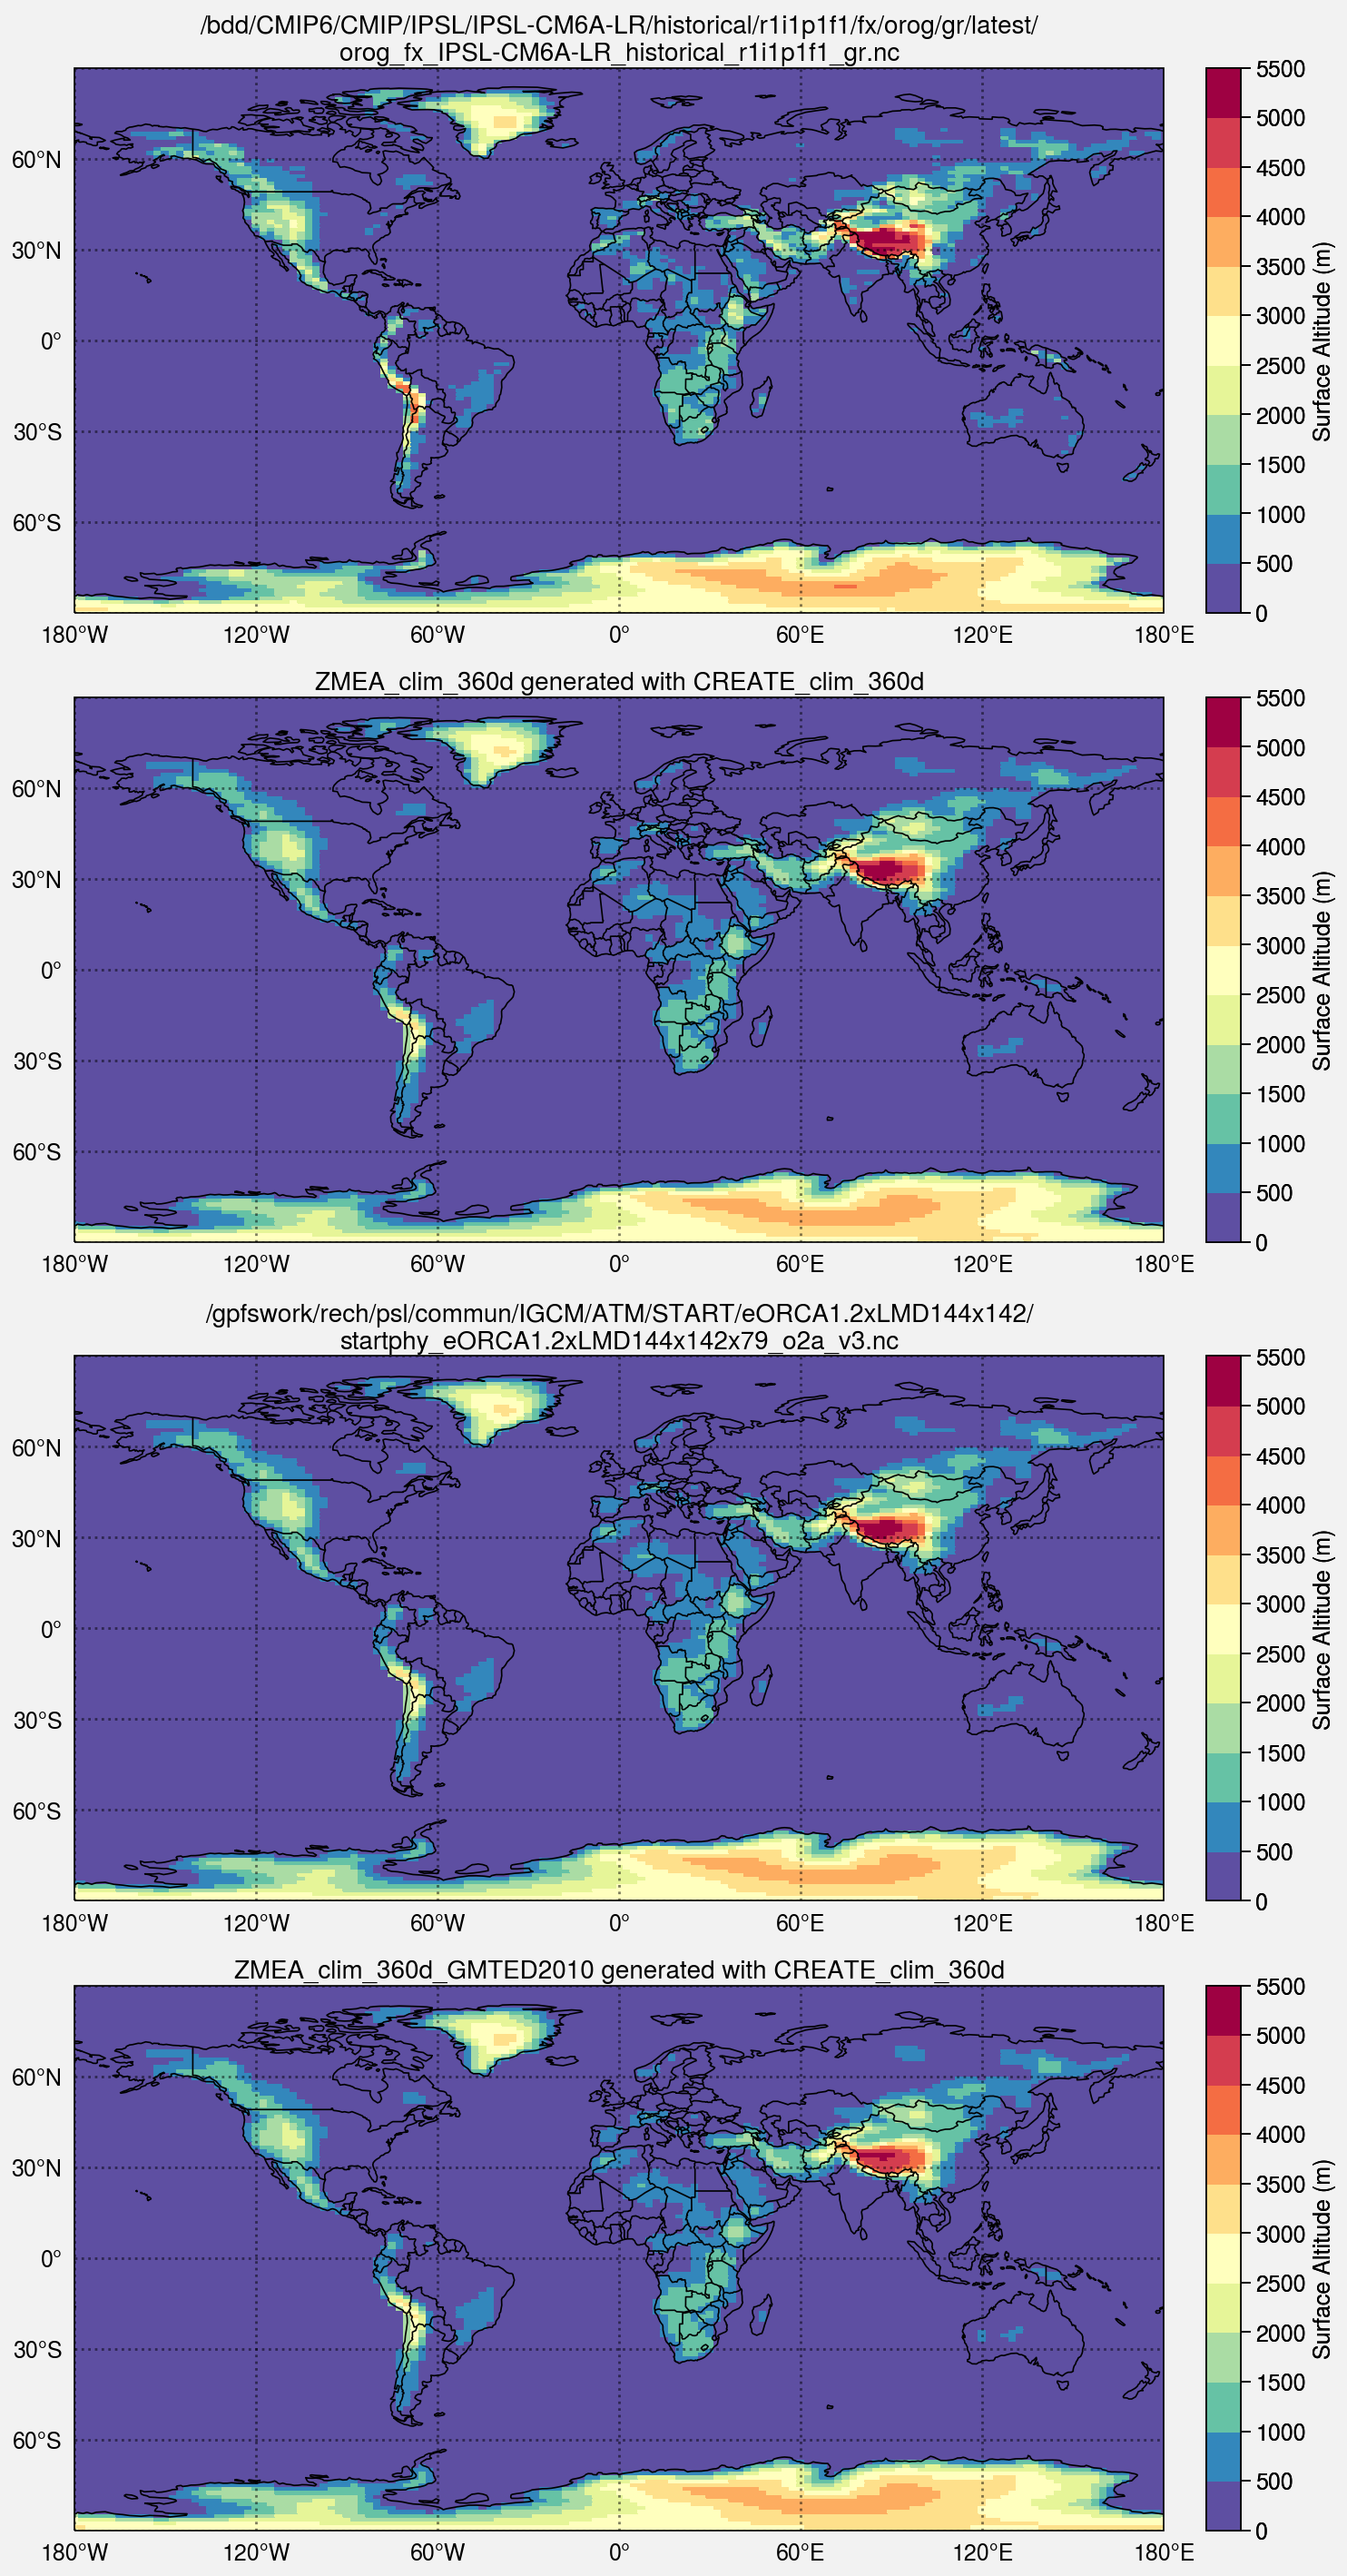

In [11]:
f, axs = plot.subplots(proj='cyl', ncols=1, nrows=4, axwidth=6)
levels=plot.arange(0,5500,500)

axs[0].pcolormesh(orog_fx_IPSL, cmap='Spectral', colorbar='r', levels=levels)
axs[0].format(title='/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/\norog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc')

axs[1].pcolormesh(ZMEA_clim_360d, cmap='Spectral', colorbar='r', levels=levels)
axs[1].format(title='ZMEA_clim_360d generated with CREATE_clim_360d')

axs[2].pcolormesh(ZMEA_amip_CMIP6, cmap='Spectral', colorbar='r', levels=levels)
axs[2].format(title='/gpfswork/rech/psl/commun/IGCM/ATM/START/eORCA1.2xLMD144x142/\nstartphy_eORCA1.2xLMD144x142x79_o2a_v3.nc')

axs[3].pcolormesh(ZMEA_clim_360d_GMTED2010, cmap='Spectral', colorbar='r', levels=levels)
axs[3].format(title='ZMEA_clim_360d_GMTED2010 generated with CREATE_clim_360d')

axs.format(labels=True, coast=True, borders=True, lonlines=60, latlines=30)

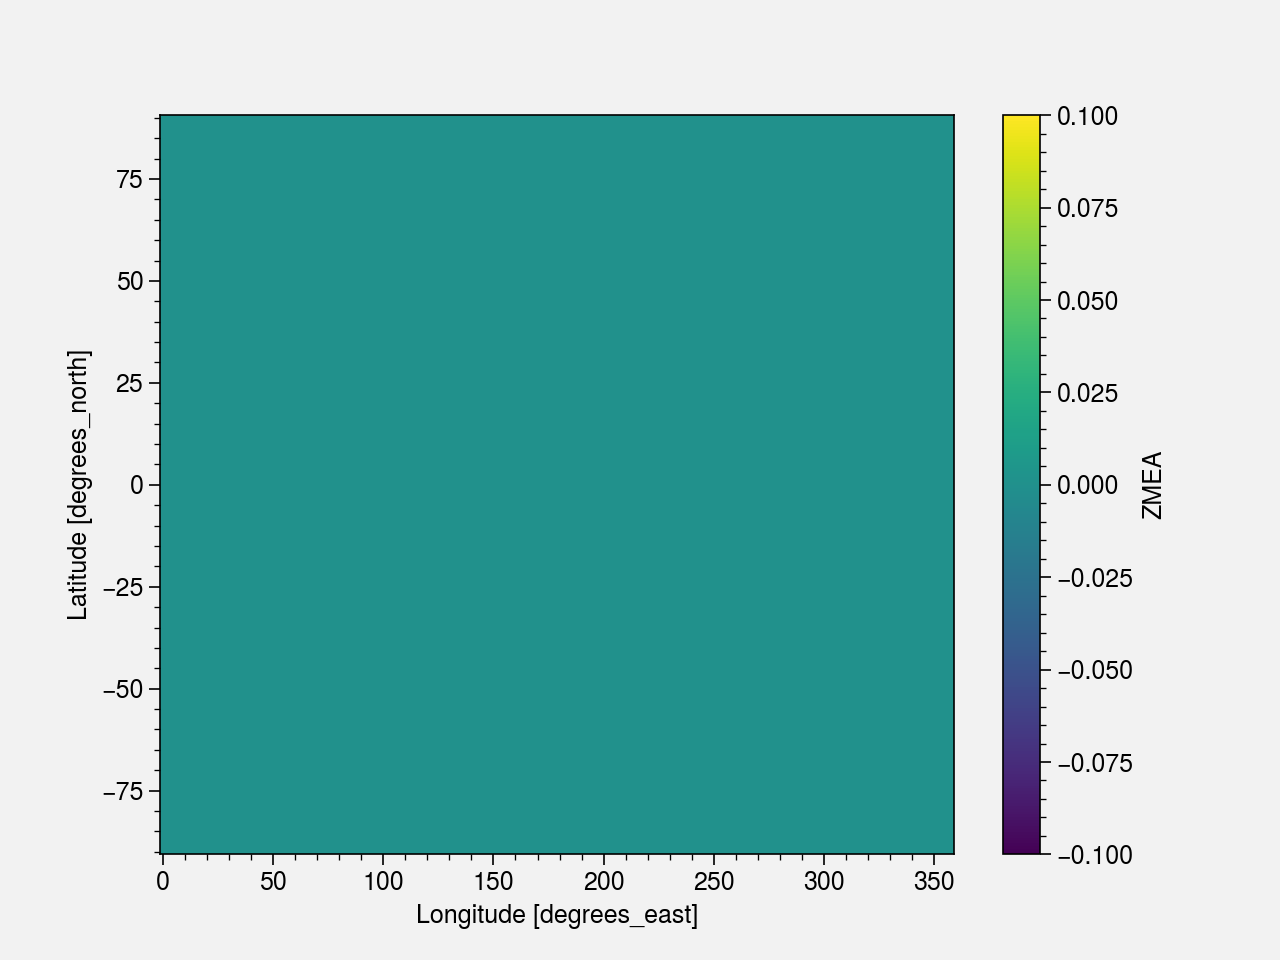

In [16]:
(ZMEA_clim_360d - ZMEA_amip_CMIP6).plot()

# phis altitude unsmoothed ??

In [27]:
phis = orog_fx_IPSL.copy()
phis.values = grilles_gcm.phis[:,:-1].roll(lonv=int(grilles_gcm.phis[:,:-1].size/2), roll_coords=True).sortby('latu').values
phis

<xarray.DataArray 'orog' (lat: 143, lon: 144)>
array([[2843.5762, 2843.5762, 2843.5762, ..., 2843.5762, 2843.5762,
        2843.5762],
       [2690.7935, 2699.8032, 2710.4067, ..., 2660.762 , 2670.0195,
        2679.723 ],
       [2620.487 , 2640.3796, 2660.6057, ..., 2564.182 , 2582.3916,
        2601.2068],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

In [35]:
phis_GMTED2010 = orog_fx_IPSL.copy()
phis_GMTED2010.values = grilles_gcm_GMTED2010.phis[:,:-1].roll(lonv=int(grilles_gcm_GMTED2010.phis[:,:-1].size/2), roll_coords=True).sortby('latu').values
phis_GMTED2010

<xarray.DataArray 'orog' (lat: 143, lon: 144)>
array([[2815.0095, 2815.0095, 2815.0095, ..., 2815.0095, 2815.0095,
        2815.0095],
       [2675.1792, 2684.377 , 2694.0303, ..., 2650.8743, 2658.4915,
        2666.5215],
       [2601.6663, 2622.457 , 2647.5898, ..., 2553.851 , 2568.661 ,
        2584.2817],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

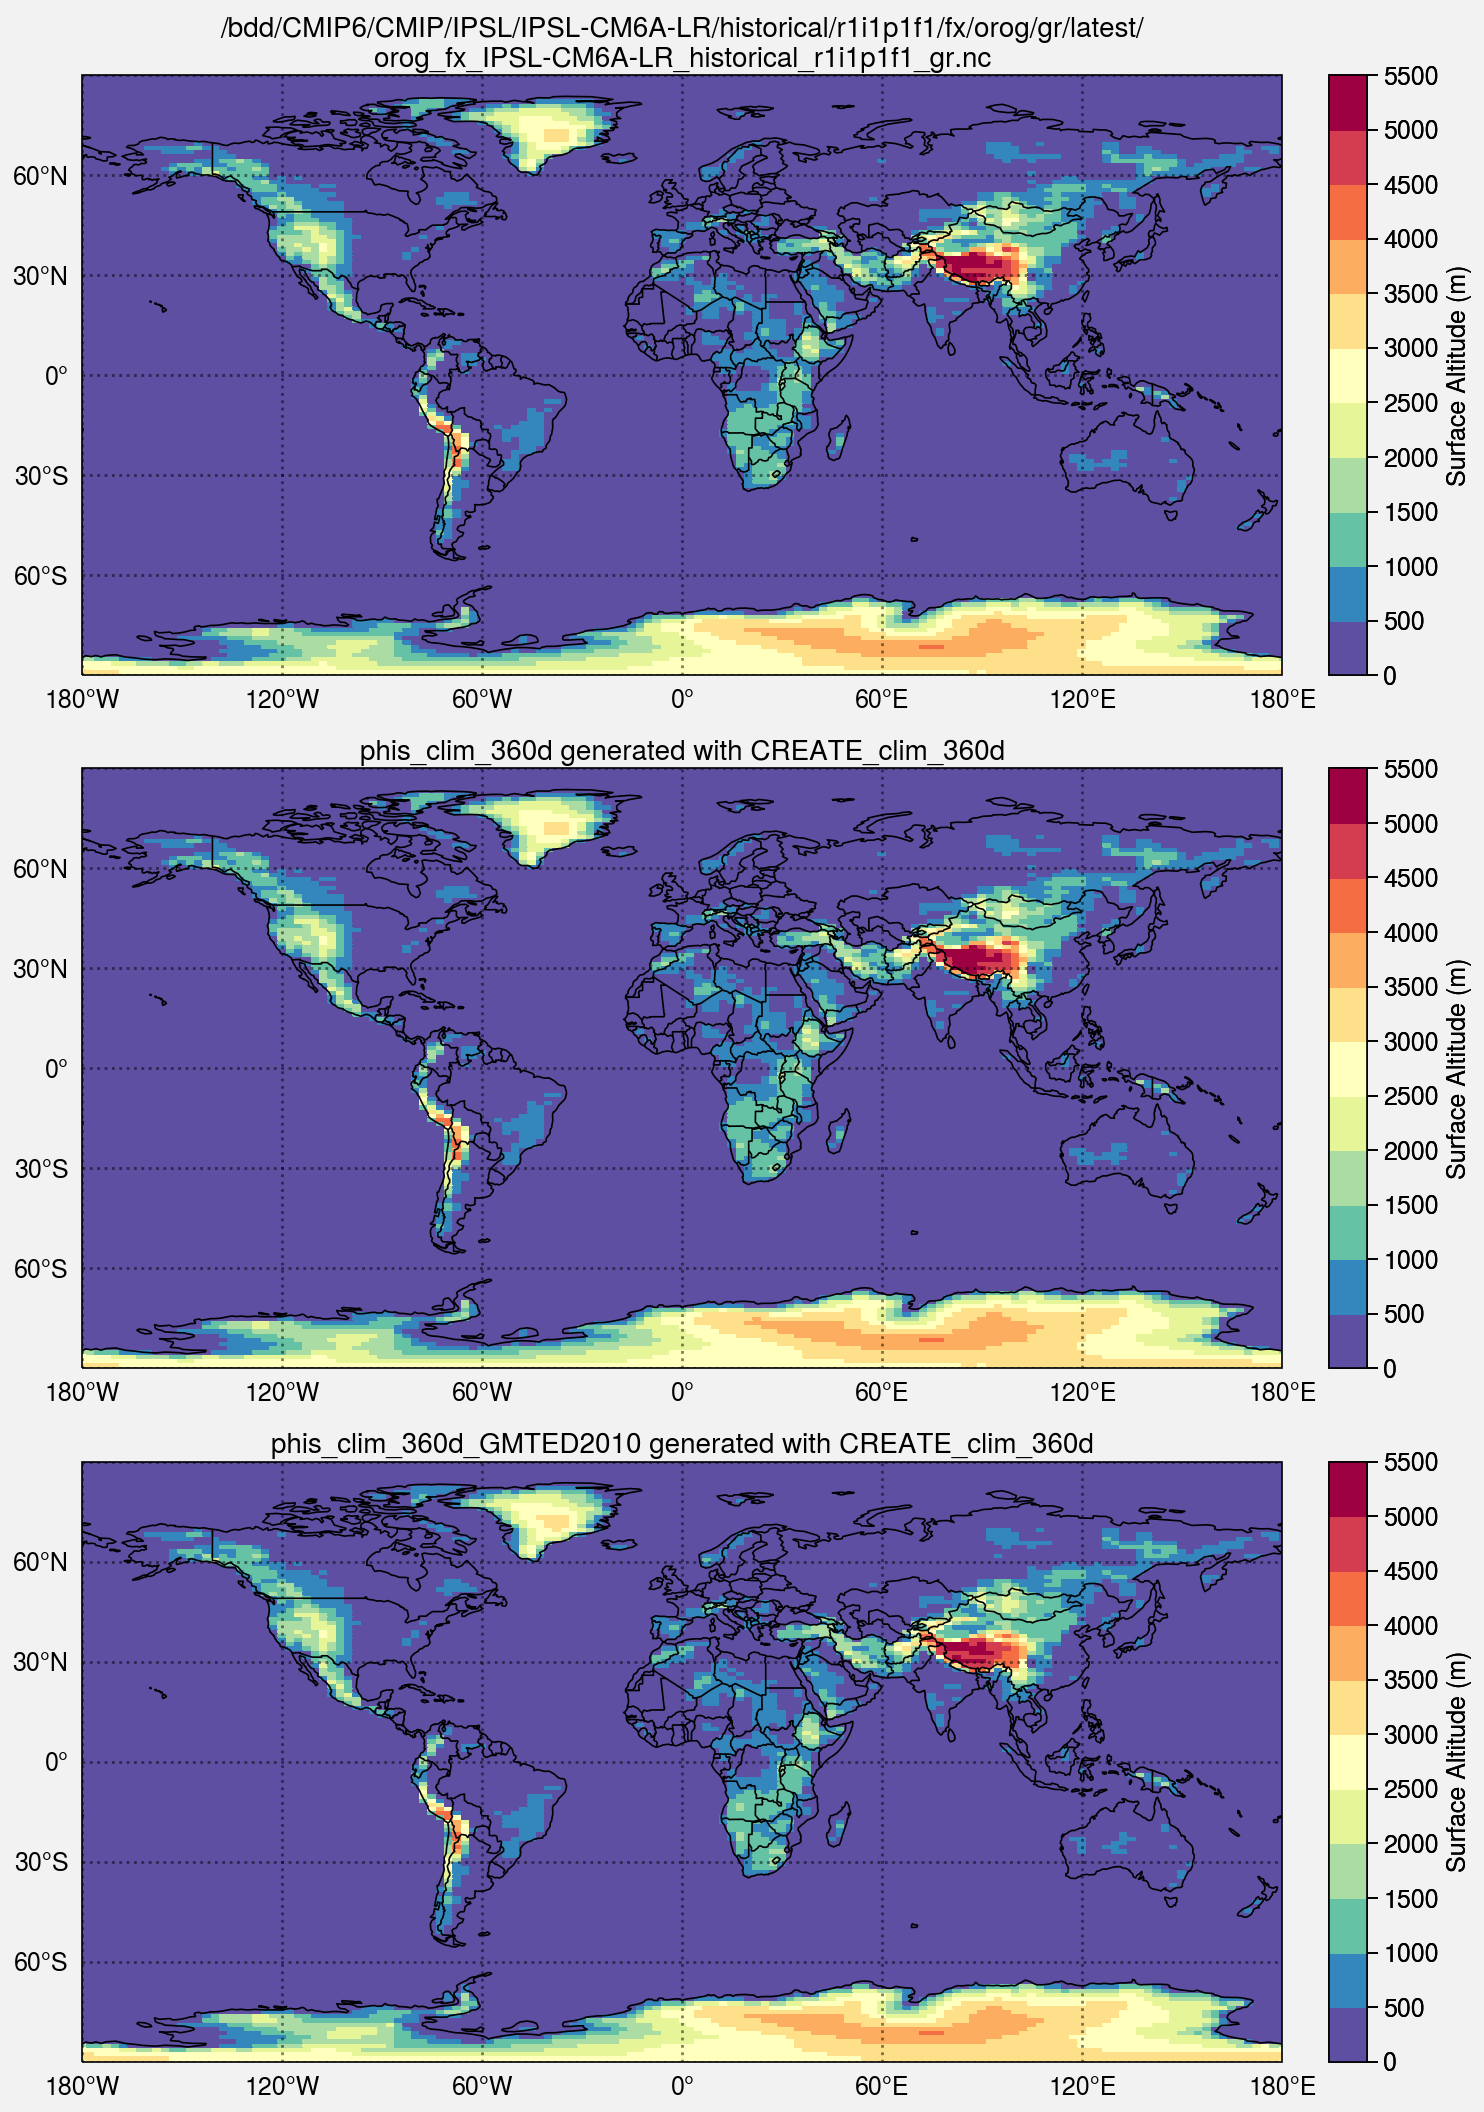

In [36]:
f, axs = plot.subplots(proj='cyl', ncols=1, nrows=3, axwidth=6)
levels=plot.arange(0,5500,500)

axs[0].pcolormesh(orog_fx_IPSL, cmap='Spectral', colorbar='r', levels=levels)
axs[0].format(title='/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/\norog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc')

axs[1].pcolormesh(phis, cmap='Spectral', colorbar='r', levels=levels)
axs[1].format(title='phis_clim_360d generated with CREATE_clim_360d')

axs[2].pcolormesh(phis_GMTED2010, cmap='Spectral', colorbar='r', levels=levels)
axs[2].format(title='phis_clim_360d_GMTED2010 generated with CREATE_clim_360d')

axs.format(labels=True, coast=True, borders=True, lonlines=60, latlines=30)

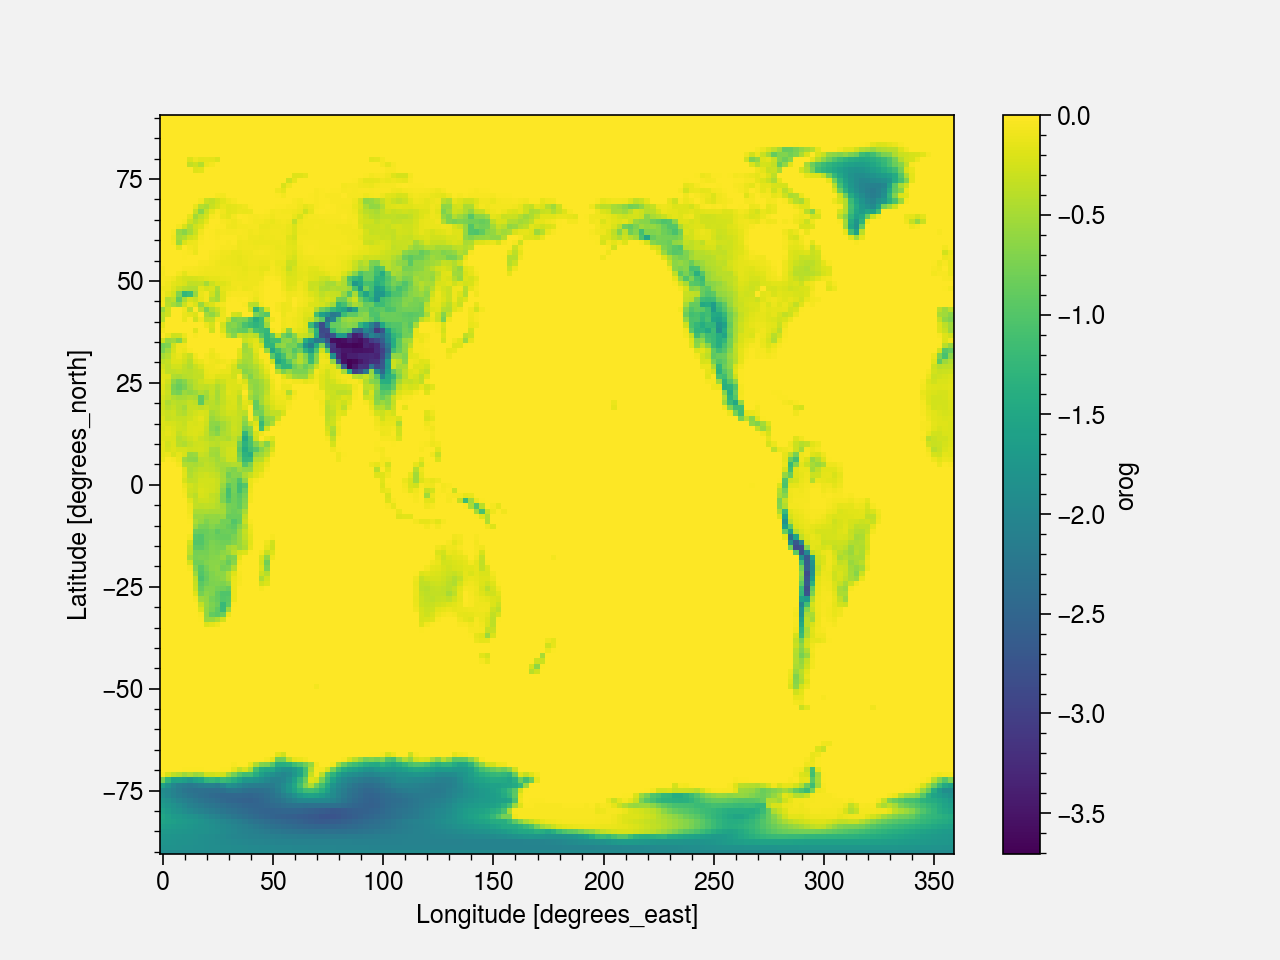

In [42]:
(orog_fx_IPSL-phis).plot()

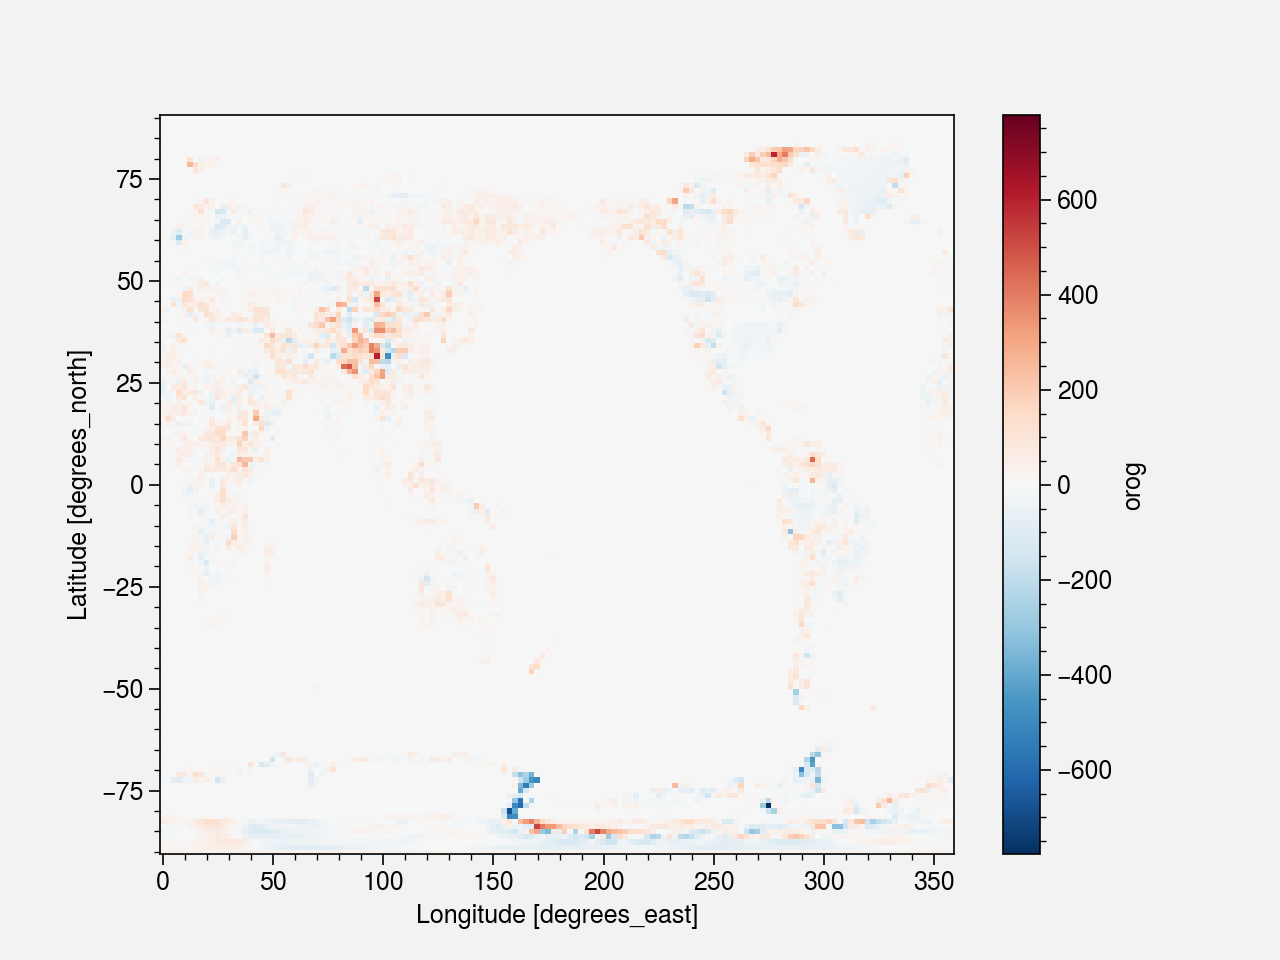

In [41]:
(orog_fx_IPSL-phis_GMTED2010).plot()

En rajoutant GMTED2010 on obtient bien un résultat différent, donc ok le ce0l prend bien en compte le fichier Relief, par contre il étale complètement les données... du coup la question c'est comment a été obtenu le fichier de CMIP6 ? Car les erreurs ont l'air démentes avec le cd0l... voir les biais à la fin

In [18]:
with xr.set_options(keep_attrs=True):
    bias = ZMEA_clim_360d - orog_fx_IPSL
bias.name = ZMEA_clim_360d.name + ' - ' + orog_fx_IPSL.name
bias.attrs['long_name'] += ' Bias'

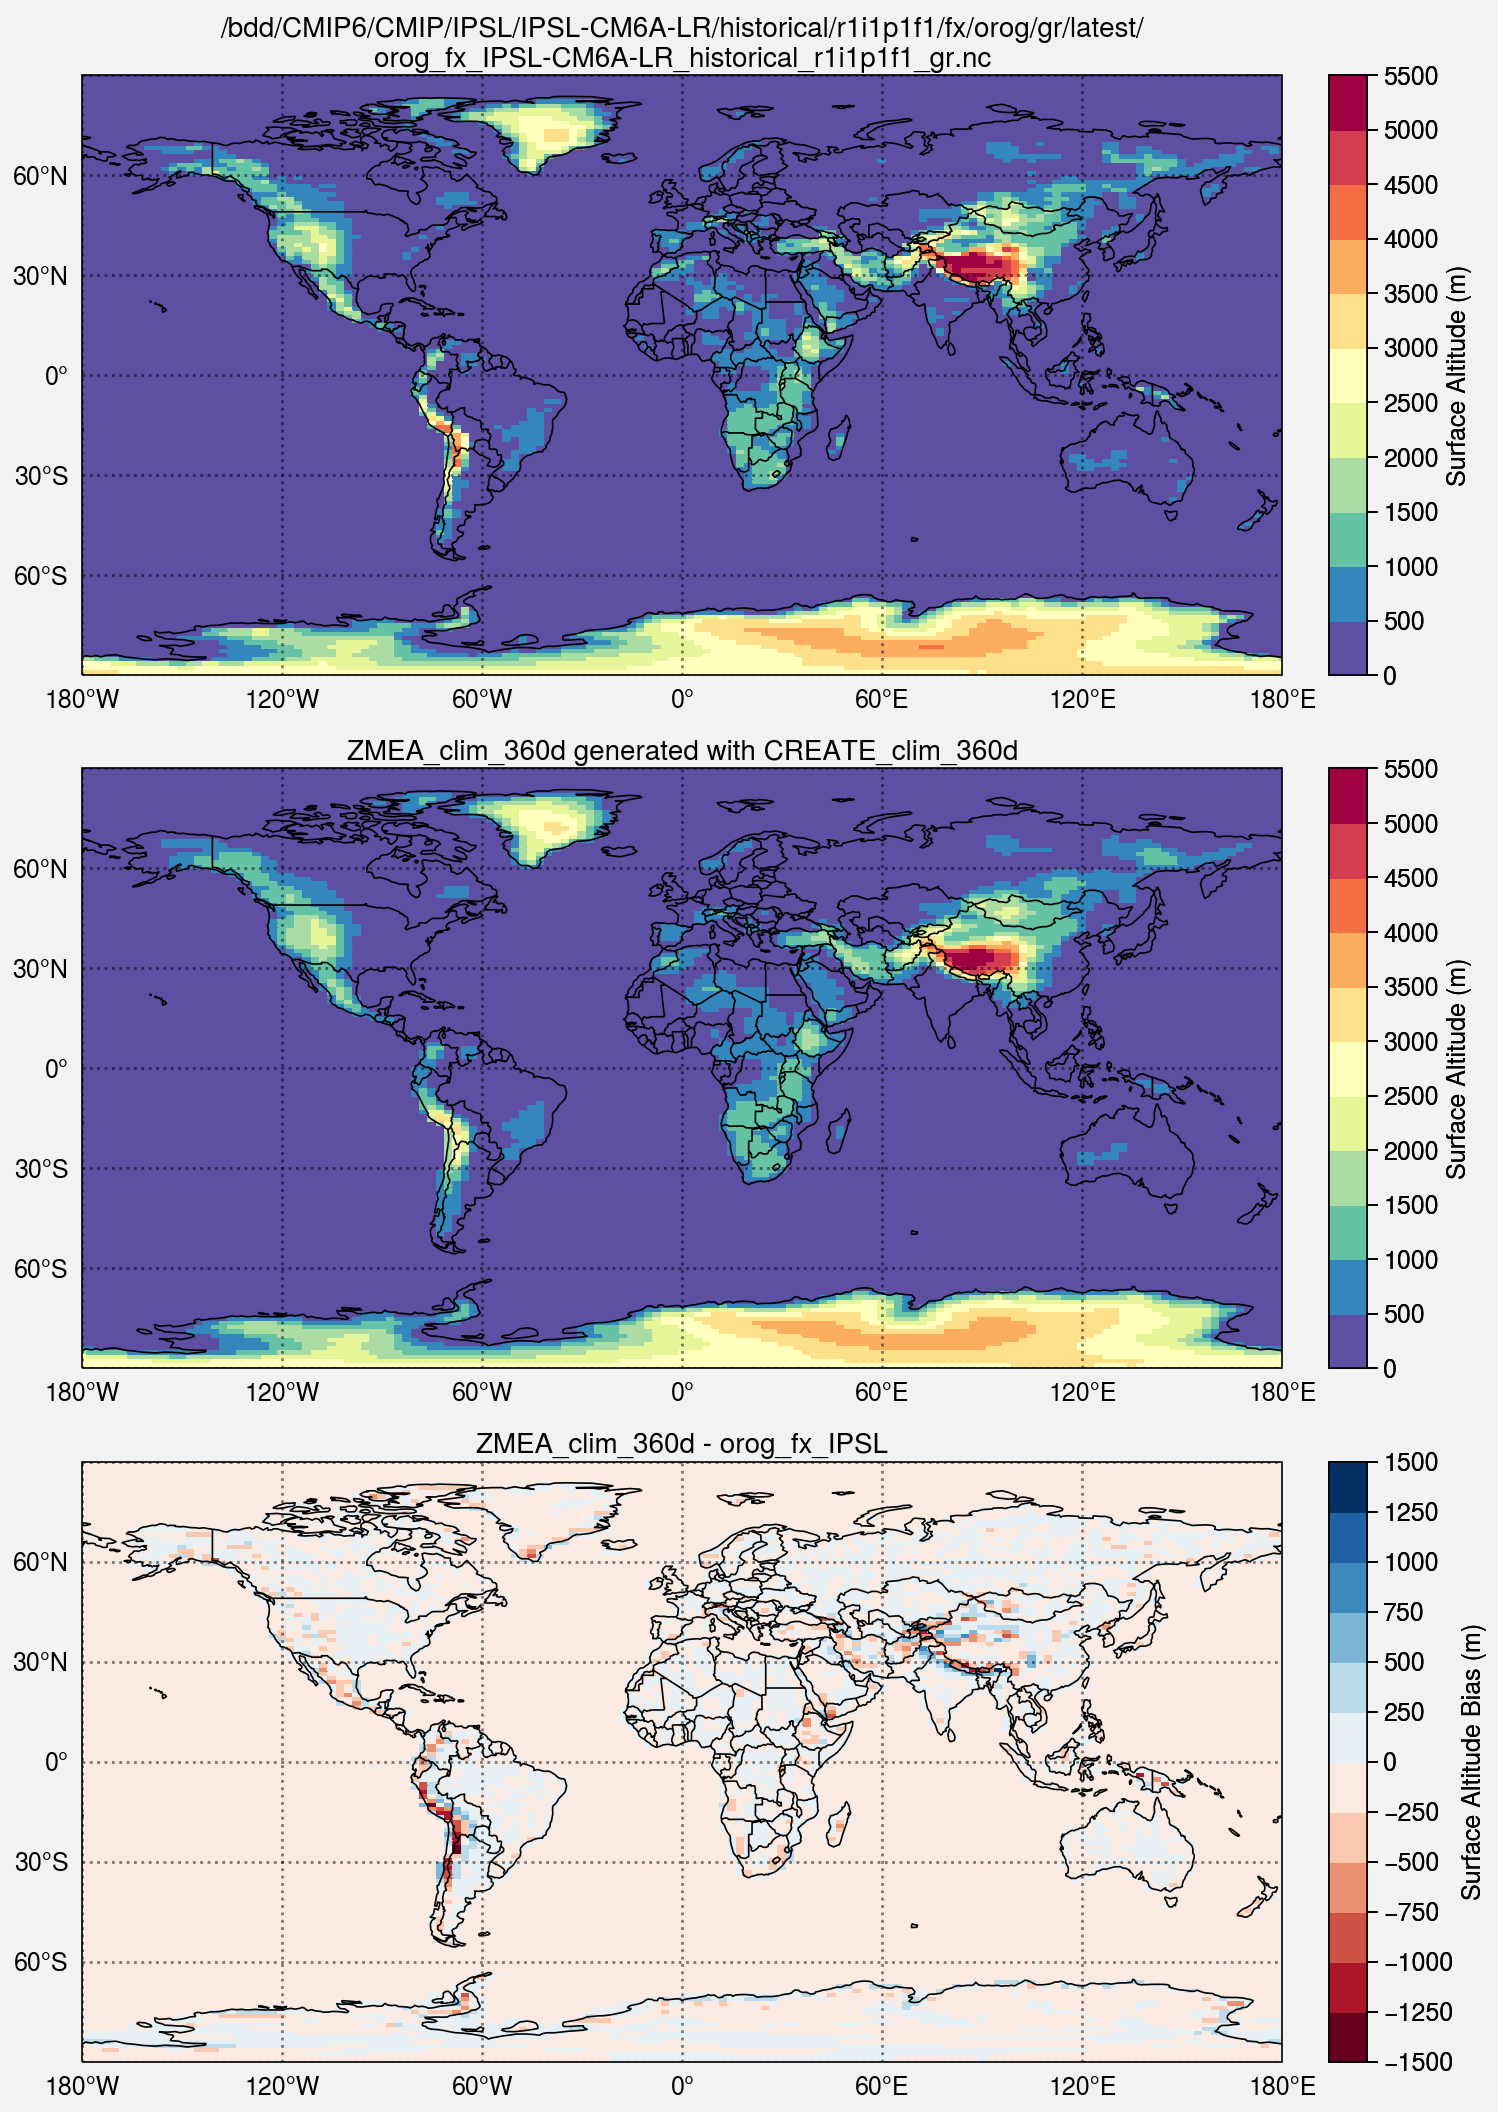

In [19]:
f, axs = plot.subplots(proj='cyl', ncols=1, nrows=3, axwidth=6)

axs[0].pcolormesh(orog_fx_IPSL, cmap='Spectral', colorbar='r')
axs[0].format(title='/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/\norog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc')

axs[1].pcolormesh(ZMEA_clim_360d, cmap='Spectral', colorbar='r')
axs[1].format(title='ZMEA_clim_360d generated with CREATE_clim_360d')

axs[2].pcolormesh(bias, cmap='RdBu', colorbar='r')
axs[2].format(title='ZMEA_clim_360d - orog_fx_IPSL')

axs.format(labels=True, coast=True, borders=True, lonlines=60, latlines=30)

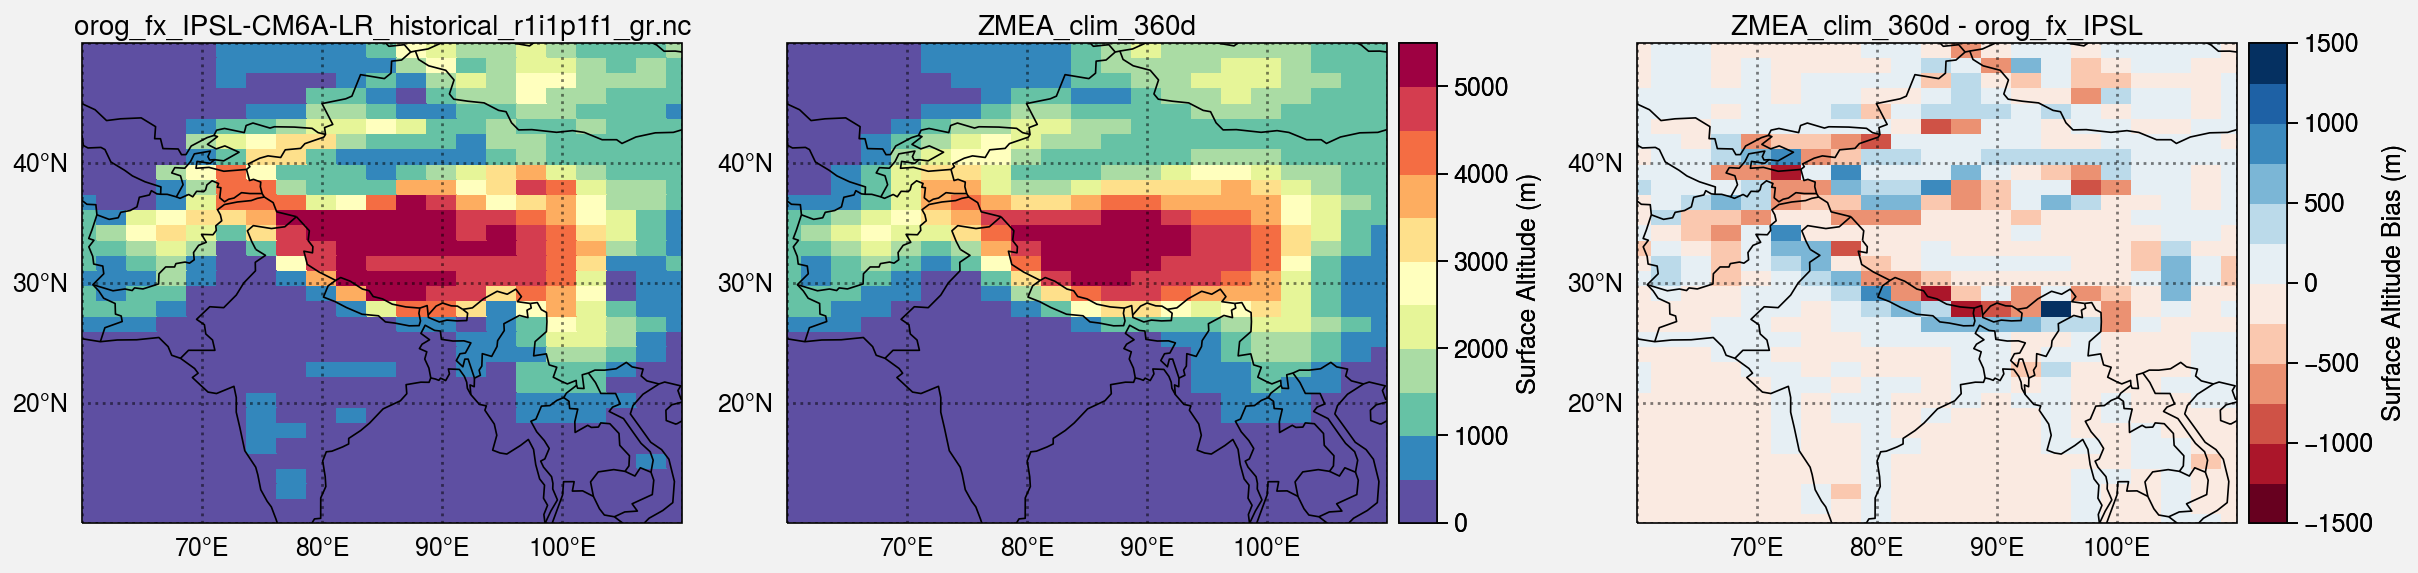

In [24]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=1, axwidth=3)

axs[0].pcolormesh(orog_fx_IPSL, cmap='Spectral')
axs[0].format(title='orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc')

axs[1].pcolormesh(ZMEA_clim_360d, cmap='Spectral', colorbar='r')
axs[1].format(title='ZMEA_clim_360d')

axs[2].pcolormesh(bias, cmap='RdBu', colorbar='r')
axs[2].format(title='ZMEA_clim_360d - orog_fx_IPSL')

axs.format(labels=True, coast=True, borders=True, lonlines=10, latlines=10, latlim=(10,50), lonlim=(60,110))

Cela ressemble à un article : https://link.springer.com/article/10.1007/s00704-018-2644-9/figures/1

Plus que ce que j'avais comparé (cf ci-dessous ou https://github.com/mickaellalande/PhD/blob/master/CICLAD/Himalaya/CMIP6_IPSL_bias/Bias%20correlation%20with%20Relief.nc.ipynb ou https://docs.google.com/document/d/1ieORG49nGEnJHfUKwj7mpK3_cjWST8fEnwGZxgs_Isg/edit?usp=sharing) et/ou la présentation de Pierre Sepulchre : https://lmdz.lmd.jussieu.fr/utilisateurs/reunion-utilisateurs/2018/jlmdz2018-sepulchre.pdf 

# Mean orography that I was computing by myself from GLOBE at 1km
Simple computation:
- without taking into account the sides
- without taking into account the area weights from each cell

See the computation: https://github.com/mickaellalande/PhD/blob/master/CICLAD/Himalaya/CMIP6_IPSL_bias/Bias%20correlation%20with%20Relief.nc.ipynb

Original file: /data/mlalande/Relief/NOAA_NGDC_GLOBE_topo_1km.nc

In [20]:
# File computed (by hand) from GLOBE 1 km
globe = xr.open_dataarray('/home/mlalande/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/mean_topo.nc')
globe

<xarray.DataArray 'orog' (lat: 143, lon: 144)>
array([[2766.2896, 2768.7498, 2771.2778, ..., 2760.2864, 2762.1475, 2762.1475],
       [2679.6423, 2688.095 , 2696.1418, ..., 2656.141 , 2663.1135, 2663.1135],
       [2600.3545, 2619.7944, 2648.6519, ..., 2556.7124, 2571.3628, 2571.3628],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

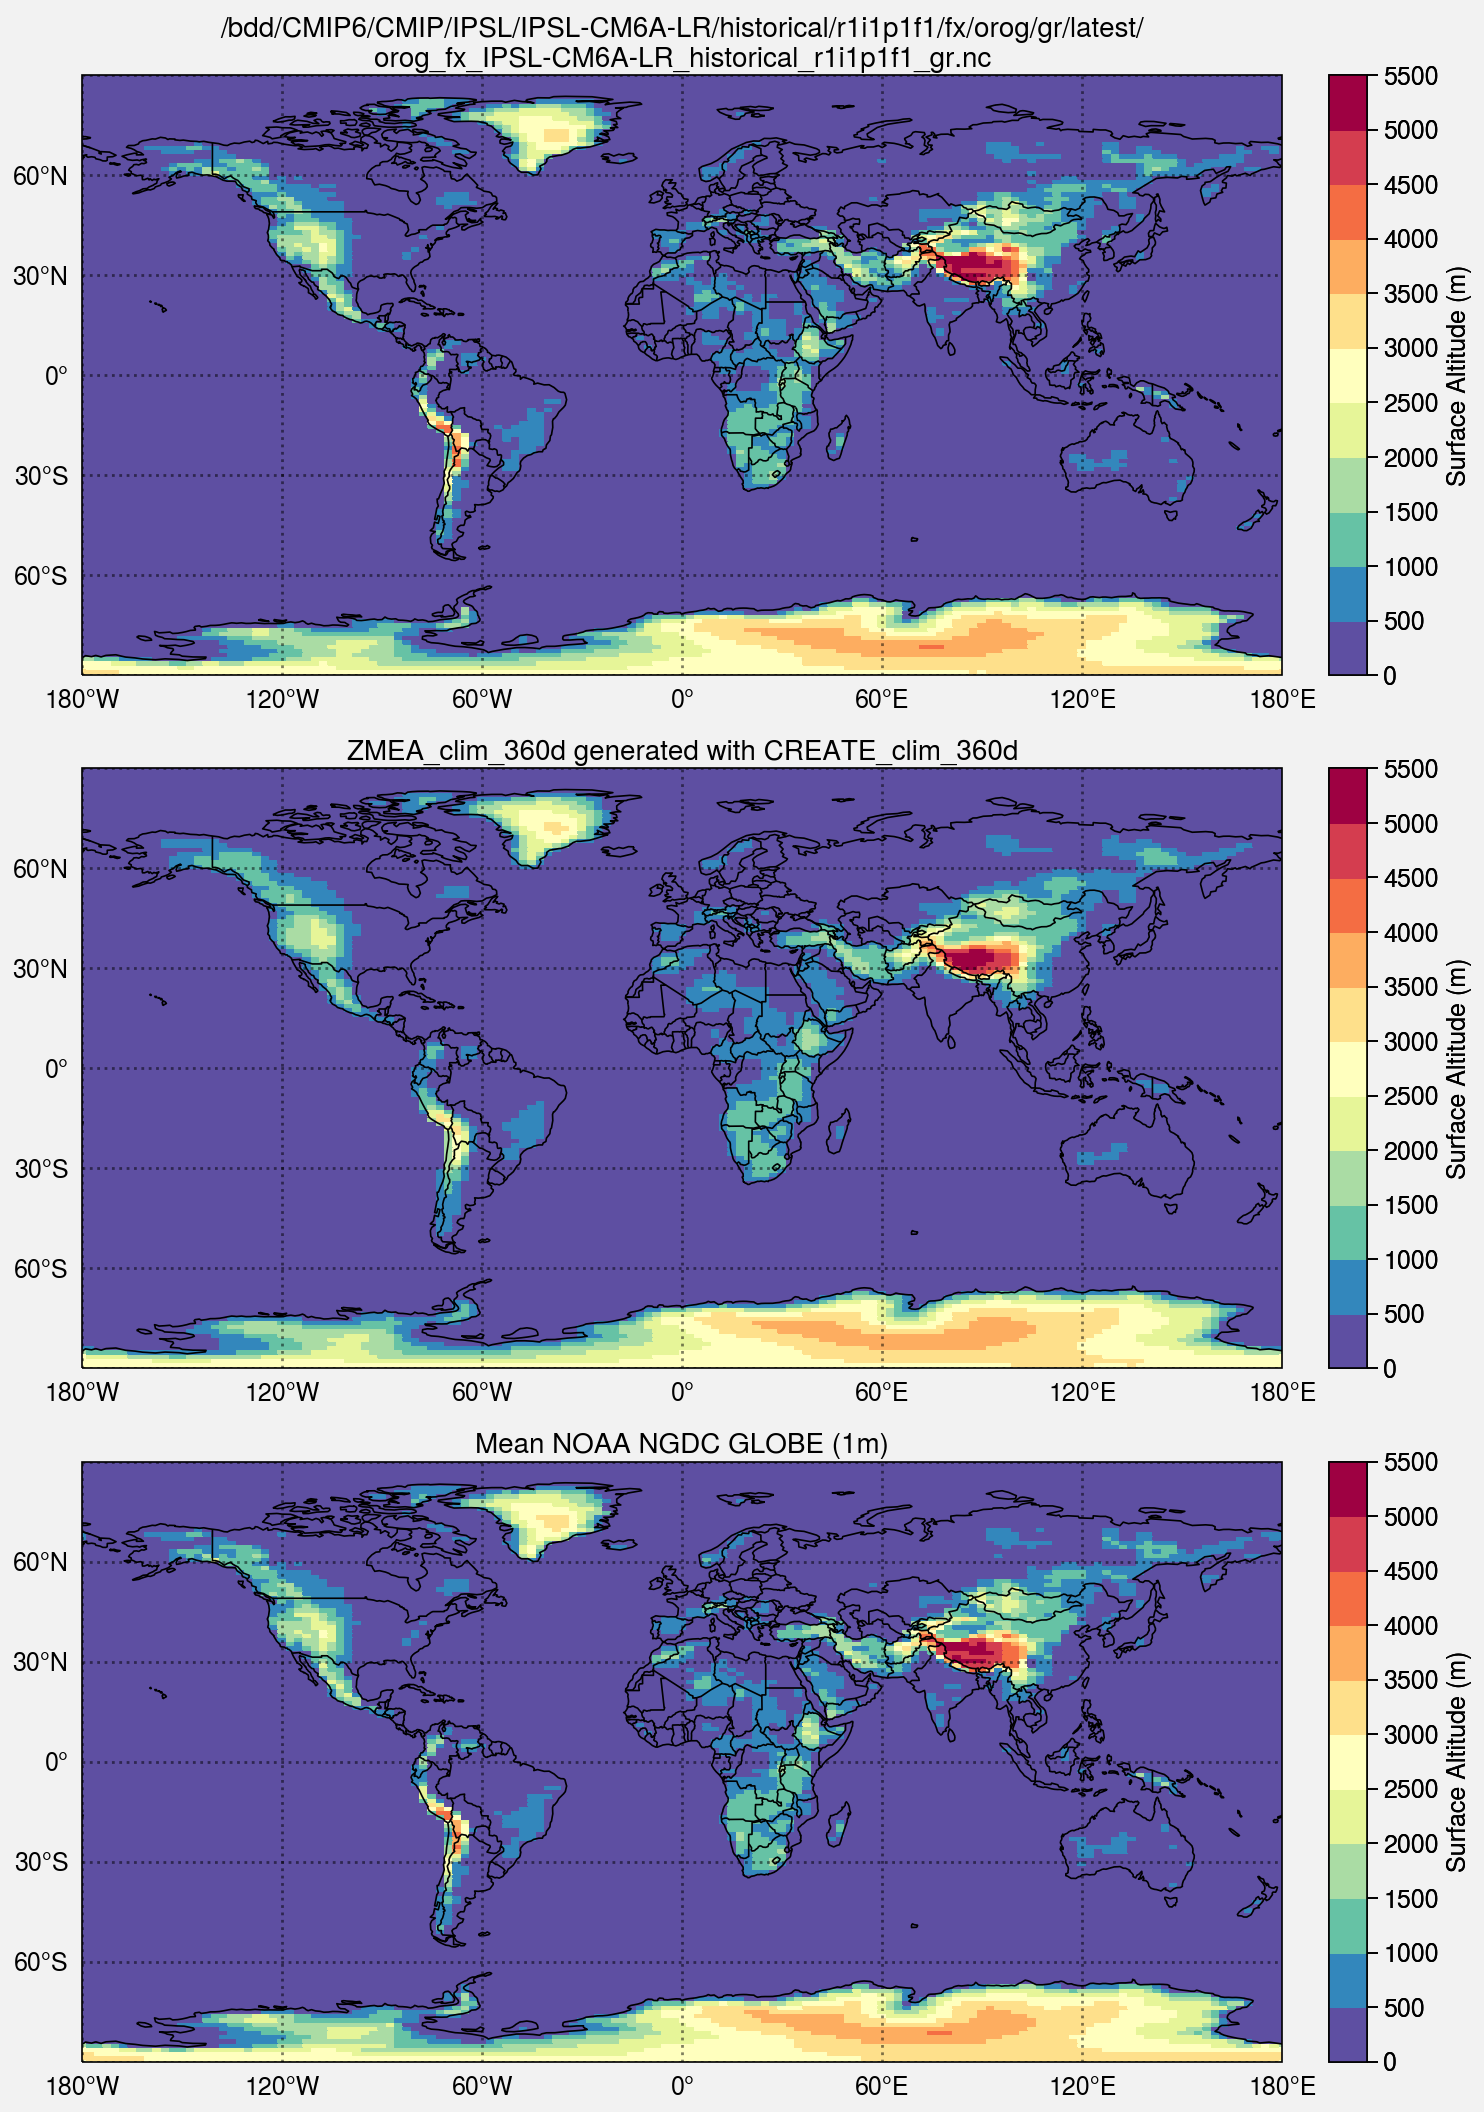

In [27]:
f, axs = plot.subplots(proj='cyl', ncols=1, nrows=3, axwidth=6)

axs[0].pcolormesh(orog_fx_IPSL, cmap='Spectral', colorbar='r')
axs[0].format(title='/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/\norog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc')

axs[1].pcolormesh(ZMEA_clim_360d, cmap='Spectral', colorbar='r')
axs[1].format(title='ZMEA_clim_360d generated with CREATE_clim_360d')

axs[2].pcolormesh(globe, cmap='Spectral', colorbar='r')
axs[2].format(title='Mean NOAA NGDC GLOBE (1m)')

axs.format(labels=True, coast=True, borders=True, lonlines=60, latlines=30)

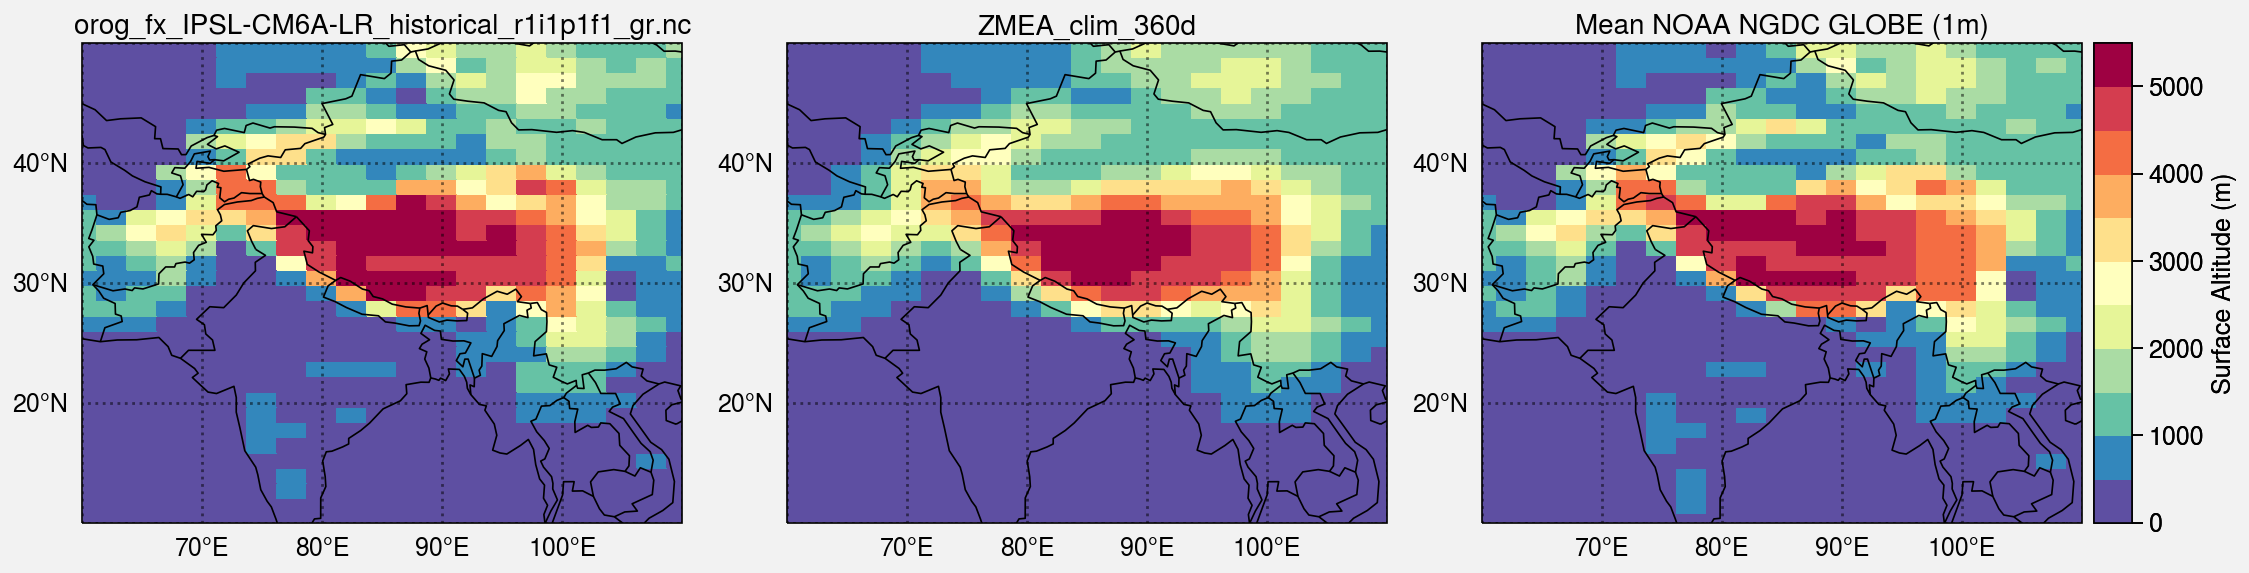

In [30]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=1, axwidth=3)
levels = plot.arange(0,5500,500)

axs[0].pcolormesh(orog_fx_IPSL, cmap='Spectral', levels=levels, colorbar=None)
axs[0].format(title='orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc')

axs[1].pcolormesh(ZMEA_clim_360d, cmap='Spectral', levels=levels, colorbar=None)
axs[1].format(title='ZMEA_clim_360d')

axs[2].pcolormesh(globe, cmap='Spectral', levels=levels, colorbar='r')
axs[2].format(title='Mean NOAA NGDC GLOBE (1m)')

axs.format(labels=True, coast=True, borders=True, lonlines=10, latlines=10, latlim=(10,50), lonlim=(60,110))

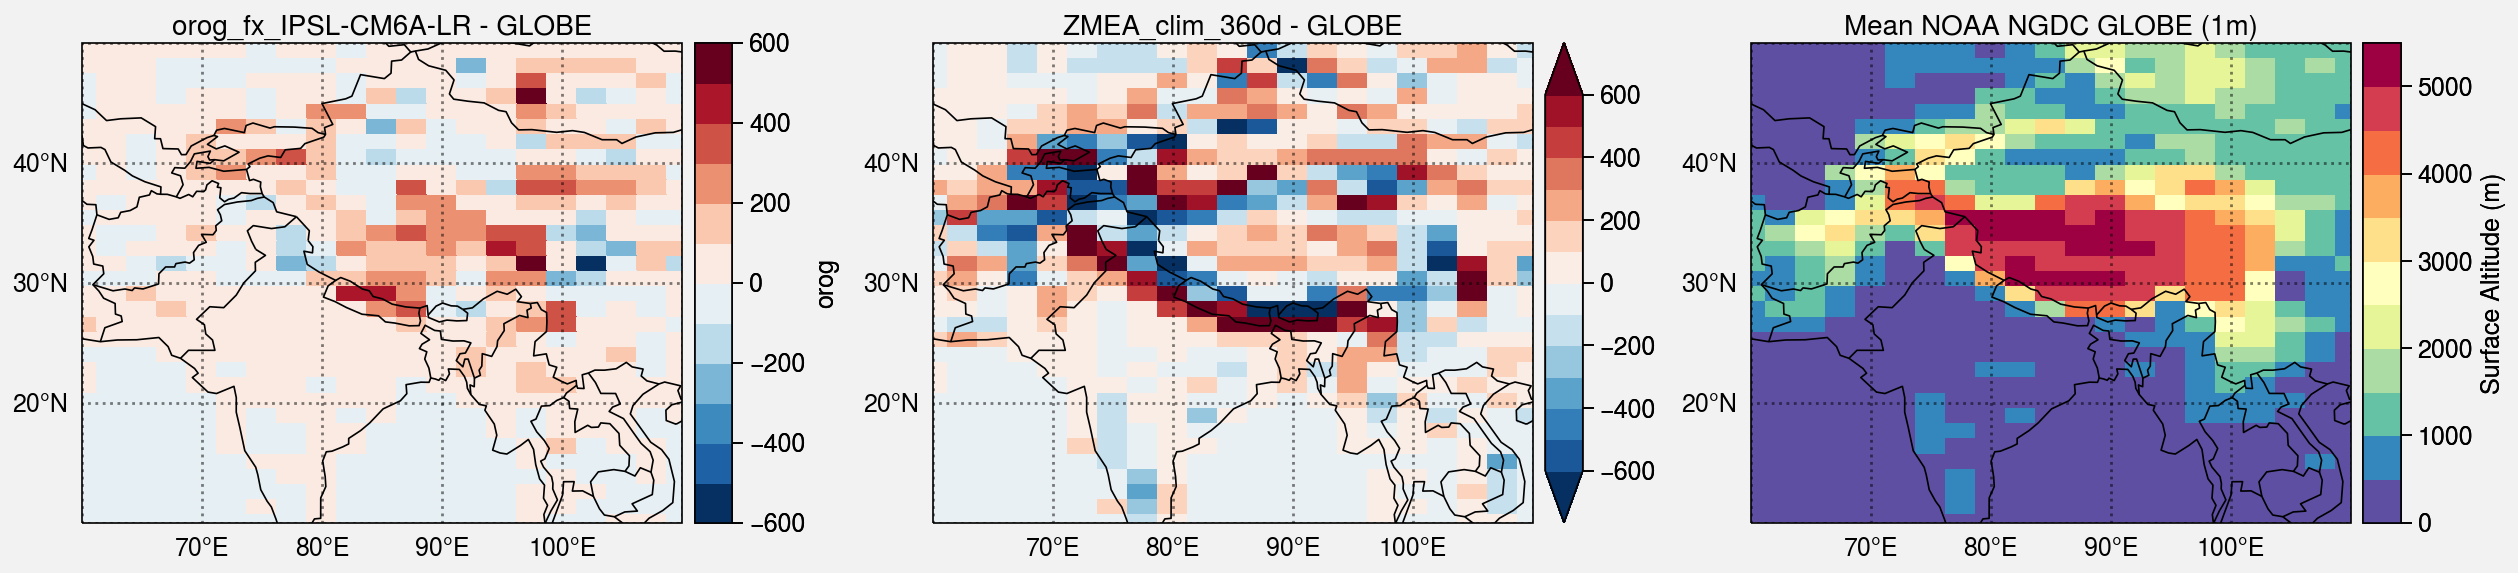

In [33]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=1, axwidth=3)
levels = plot.arange(0,5500,500)

axs[0].pcolormesh(orog_fx_IPSL - globe, cmap='BuRd', levels=plot.arange(-600,600,100), colorbar='r', extend='neither')
axs[0].format(title='orog_fx_IPSL-CM6A-LR - GLOBE')

axs[1].pcolormesh(ZMEA_clim_360d - globe, cmap='BuRd', levels=plot.arange(-600,600,100), colorbar='r', extend='both')
axs[1].format(title='ZMEA_clim_360d - GLOBE')

axs[2].pcolormesh(globe, cmap='Spectral', levels=levels, colorbar='r')
axs[2].format(title='Mean NOAA NGDC GLOBE (1m)')

axs.format(labels=True, coast=True, borders=True, lonlines=10, latlines=10, latlim=(10,50), lonlim=(60,110))

Je prends mon fichier GLOBE comme référence, mais c'est parce que c'est ce que j'ai de mieux, mais du coup la manière dont je le calcule n'ai pas forcément le top par rapport à **libf/phylmd/grid_noro_m.F90**, mais pour le moment je n'ai pas réussi à lui donner à manger mon fichier GLOBE qui est probablement trop lourd ?